In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.1.3


In [13]:
def load_images(folder_path, target_size=(32, 32), normalize=True):
    images = []
    labels = []
    class_names = []
    
    try:
        class_folders = sorted([
            f for f in os.listdir(folder_path)
            if os.path.isdir(os.path.join(folder_path, f))
        ])
        
        print(f"Found {len(class_folders)} classes: {class_folders}")
        
        for class_idx, class_name in enumerate(class_folders):
            class_names.append(class_name)
            class_path = os.path.join(folder_path, class_name)
            
            image_files = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]
            
            print(f"Loading {len(image_files)} images from class '{class_name}'...")
            
            for img_file in tqdm(image_files, desc=f"Class {class_name}"):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path)
                    img = img.convert('L')                   # grayscale
                    img = img.resize(target_size)            # resize 32×32
                    
                    img_array = np.array(img, dtype=np.float32)
                    
                    if normalize:
                        img_array = img_array / 255.0         # normalize to [0,1]
                    
                    img_array = img_array.flatten()           # flatten to (1024,)
                    
                    images.append(img_array)
                    labels.append(class_idx)
                
                except Exception as e:
                    print(f"Error loading {img_file}: {str(e)}")
                    continue
        
        images = np.array(images)
        labels = np.array(labels)
        
        print("\nDataset loaded successfully!")
        print(f"Total images: {len(images)}")
        if len(images)>0:
            print(f"Image vector shape: {images[0].shape}")  # should be 1024
        print(f"Classes: {class_names}")
        print(f"Class distribution: {np.bincount(labels)}")
        
        return images, labels, class_names
    
    except Exception as e:
        print(f"Error in load_images: {str(e)}")
        return None, None, None


In [14]:
DATASET_PATH = "./animal_dataset"

X, y, class_names = load_images(DATASET_PATH)

print("Final X shape:", X.shape)
print("Final y shape:", y.shape)

Found 3 classes: ['cat', 'dog', 'panda']
Loading 100 images from class 'cat'...


Class cat: 100%|██████████| 100/100 [00:01<00:00, 98.67it/s]


Loading 100 images from class 'dog'...


Class dog: 100%|██████████| 100/100 [00:00<00:00, 112.44it/s]


Loading 100 images from class 'panda'...


Class panda: 100%|██████████| 100/100 [00:01<00:00, 59.97it/s]


Dataset loaded successfully!
Total images: 300
Image vector shape: (1024,)
Classes: ['cat', 'dog', 'panda']
Class distribution: [100 100 100]
Final X shape: (300, 1024)
Final y shape: (300,)


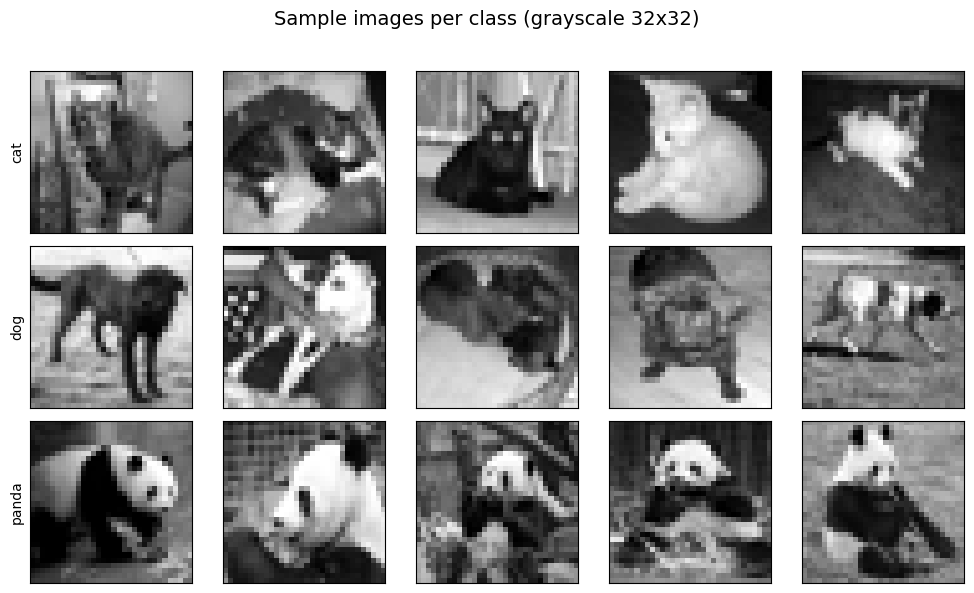

In [15]:
def show_samples_per_class(X_flat, y, class_names, samples_per_class=5):
    h = 32; w = 32
    n_classes = len(class_names)
    plt.figure(figsize=(samples_per_class * 2, n_classes * 2))
    
    for ci, cname in enumerate(class_names):
        idxs = np.where(y == ci)[0]
        if len(idxs) == 0:
            continue
        sel = idxs[:samples_per_class] if len(idxs) >= samples_per_class else idxs
        for j, idx in enumerate(sel):
            plt_idx = ci * samples_per_class + j + 1
            plt.subplot(n_classes, samples_per_class, plt_idx)
            plt.imshow(X_flat[idx].reshape(h, w), cmap='gray')
            if j == 0:
                plt.ylabel(cname, fontsize=10)
            plt.xticks([])
            plt.yticks([])
    plt.suptitle("Sample images per class (grayscale 32x32)", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

show_samples_per_class(X, y, class_names, samples_per_class=5)


# Distance Functions

In [16]:
def L1_distance(a, b):
    return np.sum(np.abs(a - b))

def L2_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# KNN Prediction

In [17]:
def get_k_neighbors(test_sample, X_train, y_train, k=3, distance='l2'):
    dists = []
    if distance == 'l1':
        for i in range(len(X_train)):
            d = L1_distance(test_sample, X_train[i])
            dists.append((d, y_train[i], i))
    else:
        for i in range(len(X_train)):
            d = L2_distance(test_sample, X_train[i])
            dists.append((d, y_train[i], i))
    dists.sort(key=lambda x: x[0])
    return dists[:k]

def knn_predict_label(test_sample, X_train, y_train, k=3, distance='l2'):
    neighbors = get_k_neighbors(test_sample, X_train, y_train, k=k, distance=distance)
    labels = [n[1] for n in neighbors]
    vals, counts = np.unique(labels, return_counts=True)
    max_count = counts.max()
    candidates = vals[counts == max_count]
    if len(candidates) == 1:
        return candidates[0]
    # tie-breaker: choose candidate with smallest average distance among neighbors
    avg_dist = {}
    for c in candidates:
        avg_dist[c] = np.mean([n[0] for n in neighbors if n[1] == c])
    return min(avg_dist, key=avg_dist.get)


# 5-fold

# 5-fold

In [19]:
def get_stratified_folds(y, k=5, random_state=None):
    # Simple stratified-ish folding: shuffle within each class then concatenate
    if random_state is not None:
        np.random.seed(random_state)
    classes = np.unique(y)
    folds = [[] for _ in range(k)]
    for c in classes:
        idxs = np.where(y==c)[0]
        np.random.shuffle(idxs)
        for i, idx in enumerate(idxs):
            folds[i % k].append(idx)
    folds = [np.array(f, dtype=int) for f in folds]
    return folds


# Cross Val

In [20]:
def cross_validate_knn(X, y, k_values, distance='l2', folds=None):
    if folds is None:
        folds = get_stratified_folds(y, k=5, random_state=42)
    avg_accs = []
    for k_val in k_values:
        fold_accs = []
        print(f"\nEvaluating distance={distance}, k={k_val}")
        for i in range(len(folds)):
            val_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(len(folds)) if j != i])
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            correct = 0
            for j in range(len(X_val)):
                pred = knn_predict_label(X_val[j], X_train, y_train, k=k_val, distance=distance)
                if pred == y_val[j]:
                    correct += 1
            acc = correct / len(X_val)
            print(f" Fold {i+1} acc: {acc:.3f}")
            fold_accs.append(acc)
        avg = np.mean(fold_accs)
        print(f" -> Average acc for k={k_val}: {avg:.3f}")
        avg_accs.append(avg)
    return avg_accs



Evaluating distance=l1, k=1
 Fold 1 acc: 0.433
 Fold 2 acc: 0.467
 Fold 3 acc: 0.350
 Fold 4 acc: 0.267
 Fold 5 acc: 0.450
 -> Average acc for k=1: 0.393

Evaluating distance=l1, k=2
 Fold 1 acc: 0.433
 Fold 2 acc: 0.467
 Fold 3 acc: 0.350
 Fold 4 acc: 0.267
 Fold 5 acc: 0.450
 -> Average acc for k=2: 0.393

Evaluating distance=l1, k=3
 Fold 1 acc: 0.483
 Fold 2 acc: 0.450
 Fold 3 acc: 0.317
 Fold 4 acc: 0.367
 Fold 5 acc: 0.500
 -> Average acc for k=3: 0.423

Evaluating distance=l1, k=4
 Fold 1 acc: 0.450
 Fold 2 acc: 0.467
 Fold 3 acc: 0.350
 Fold 4 acc: 0.433
 Fold 5 acc: 0.500
 -> Average acc for k=4: 0.440

Evaluating distance=l1, k=5
 Fold 1 acc: 0.433
 Fold 2 acc: 0.467
 Fold 3 acc: 0.350
 Fold 4 acc: 0.467
 Fold 5 acc: 0.483
 -> Average acc for k=5: 0.440

Evaluating distance=l1, k=6
 Fold 1 acc: 0.500
 Fold 2 acc: 0.400
 Fold 3 acc: 0.367
 Fold 4 acc: 0.383
 Fold 5 acc: 0.433
 -> Average acc for k=6: 0.417

Evaluating distance=l1, k=7
 Fold 1 acc: 0.417
 Fold 2 acc: 0.467
 Fo

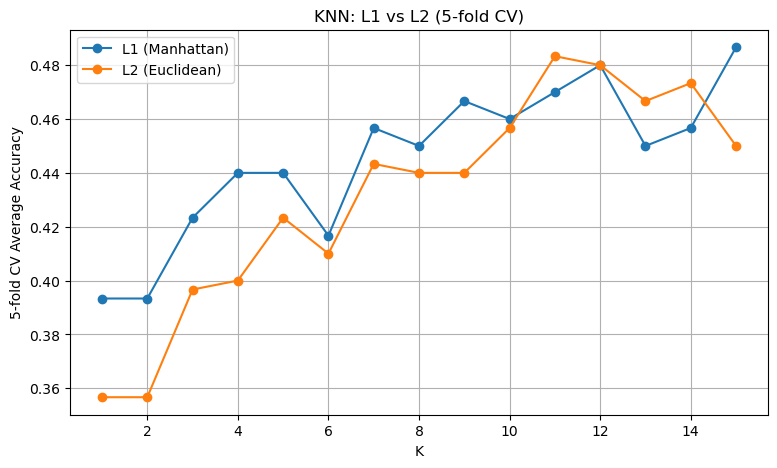

In [21]:
k_values = list(range(1, 16))
folds = get_stratified_folds(y, k=5, random_state=42)  # use same folds for fair compare

acc_l1 = cross_validate_knn(X, y, k_values, distance='l1', folds=folds)
acc_l2 = cross_validate_knn(X, y, k_values, distance='l2', folds=folds)

plt.figure(figsize=(9,5))
plt.plot(k_values, acc_l1, label='L1 (Manhattan)', marker='o')
plt.plot(k_values, acc_l2, label='L2 (Euclidean)', marker='o')
plt.xlabel('K')
plt.ylabel('5-fold CV Average Accuracy')
plt.title('KNN: L1 vs L2 (5-fold CV)')
plt.legend()
plt.grid(True)
plt.show()

# Top 5 prediction

In [22]:
# If you have a test folder, set TEST_PATH to it. If not, leave None to auto-select.
TEST_PATH = None   # e.g., "./animal_dataset_test" or None

def get_test_examples(X, y, class_names, test_path=None, n_test=5, random_state=42):
    if test_path and os.path.isdir(test_path):
        files = [f for f in sorted(os.listdir(test_path)) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]
        tests = []
        for f in files[:n_test]:
            img = Image.open(os.path.join(test_path, f)).convert('L').resize((32,32))
            arr = np.array(img, dtype=np.float32)/255.0
            tests.append((f, arr.flatten()))
        return tests, None, None
    else:
        # create hold-out: sample n_test indices from X and return them plus new train set indices
        np.random.seed(random_state)
        all_idx = np.arange(len(X))
        chosen = np.random.choice(all_idx, size=n_test, replace=False)
        remaining = np.setdiff1d(all_idx, chosen)
        tests = [('holdout_'+str(i), X[idx]) for i, idx in enumerate(chosen)]
        return tests, chosen, remaining

tests, test_indices, remaining_idx = get_test_examples(X, y, class_names, test_path=TEST_PATH, n_test=5)
print("Using", len(tests), "test examples.")


Using 5 test examples.


# Prediction

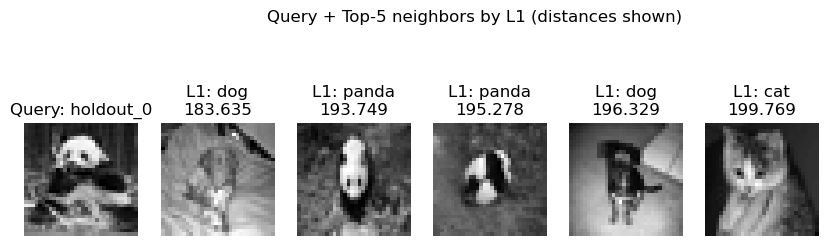

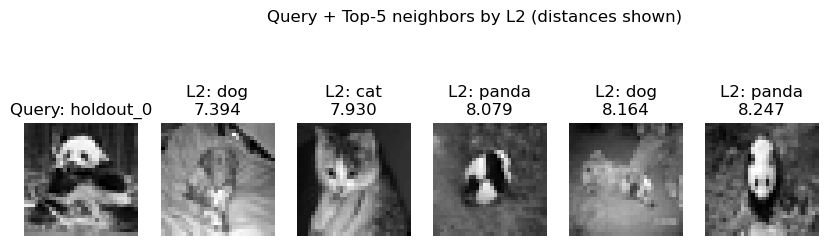

Query=holdout_0  --> Pred L1 (k=3): panda | Pred L2 (k=3): dog
------------------------------------------------------------


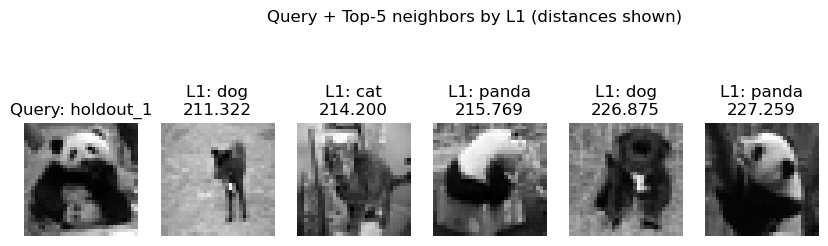

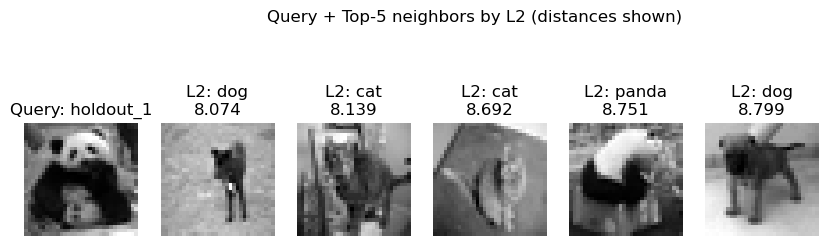

Query=holdout_1  --> Pred L1 (k=3): dog | Pred L2 (k=3): cat
------------------------------------------------------------


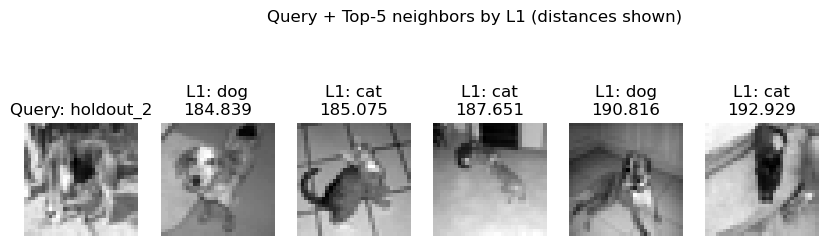

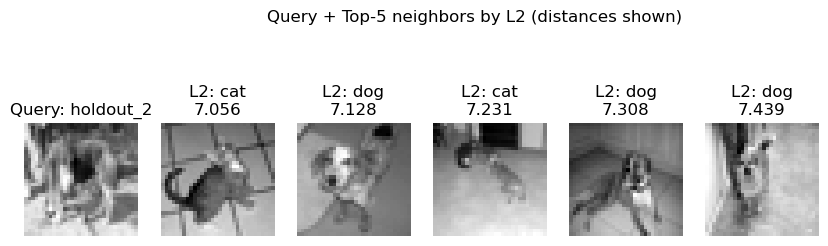

Query=holdout_2  --> Pred L1 (k=3): cat | Pred L2 (k=3): cat
------------------------------------------------------------


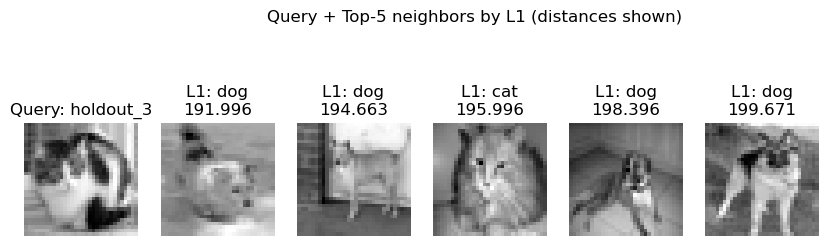

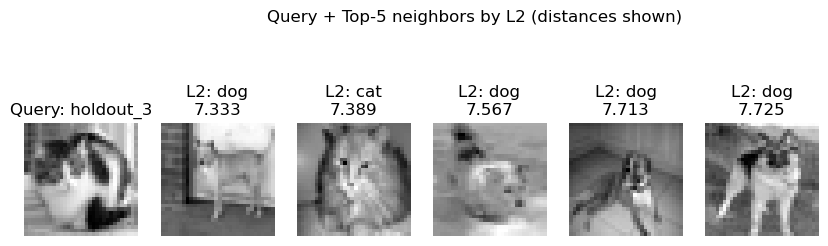

Query=holdout_3  --> Pred L1 (k=3): dog | Pred L2 (k=3): dog
------------------------------------------------------------


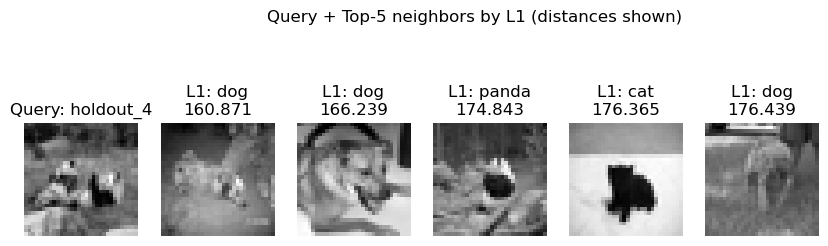

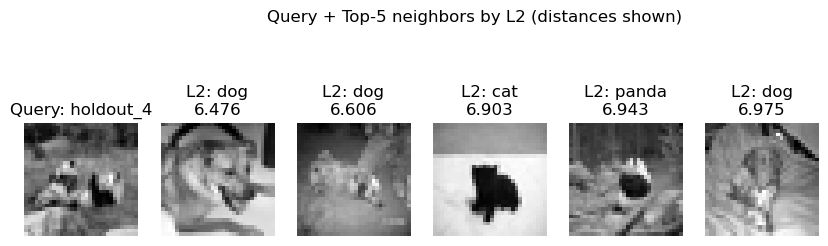

Query=holdout_4  --> Pred L1 (k=3): dog | Pred L2 (k=3): dog
------------------------------------------------------------


In [23]:
def visualize_topk_for_tests(tests, X_full, y_full, class_names, k_neighbors=5, k_vote=3):
    h,w = 32,32
    for name, arr in tests:
        fig = plt.figure(figsize=(12, 3.5))
        # show query
        axq = plt.subplot2grid((1, 7), (0, 0), colspan=1)
        axq.imshow(arr.reshape(h,w), cmap='gray')
        axq.set_title(f"Query: {name}")
        axq.axis('off')
        
        # L1 neighbors
        neighbors_l1 = get_k_neighbors(arr, X_full, y_full, k=k_neighbors, distance='l1')
        axpos = 1
        for d, lbl, idx in neighbors_l1:
            ax = plt.subplot2grid((1, 7), (0, axpos))
            ax.imshow(X_full[idx].reshape(h,w), cmap='gray')
            ax.set_title(f"L1: {class_names[lbl]}\n{d:.3f}")
            ax.axis('off')
            axpos += 1
        plt.suptitle("Query + Top-5 neighbors by L1 (distances shown)", fontsize=12)
        plt.show()
        
        # L2 neighbors
        fig = plt.figure(figsize=(12, 3.5))
        axq = plt.subplot2grid((1, 7), (0, 0), colspan=1)
        axq.imshow(arr.reshape(h,w), cmap='gray')
        axq.set_title(f"Query: {name}")
        axq.axis('off')
        
        neighbors_l2 = get_k_neighbors(arr, X_full, y_full, k=k_neighbors, distance='l2')
        axpos = 1
        for d, lbl, idx in neighbors_l2:
            ax = plt.subplot2grid((1, 7), (0, axpos))
            ax.imshow(X_full[idx].reshape(h,w), cmap='gray')
            ax.set_title(f"L2: {class_names[lbl]}\n{d:.3f}")
            ax.axis('off')
            axpos += 1
        plt.suptitle("Query + Top-5 neighbors by L2 (distances shown)", fontsize=12)
        plt.show()
        
        # Predictions by majority (k_vote)
        pred_l1 = knn_predict_label(arr, X_full, y_full, k=k_vote, distance='l1')
        pred_l2 = knn_predict_label(arr, X_full, y_full, k=k_vote, distance='l2')
        print(f"Query={name}  --> Pred L1 (k={k_vote}): {class_names[pred_l1]} | Pred L2 (k={k_vote}): {class_names[pred_l2]}")
        print("-"*60)

# Use remaining_idx as training set if holdout was used, otherwise use full X
if remaining_idx is not None:
    X_train_final = X[remaining_idx]
    y_train_final = y[remaining_idx]
else:
    X_train_final = X
    y_train_final = y

visualize_topk_for_tests(tests, X_train_final, y_train_final, class_names, k_neighbors=5, k_vote=3)


# Cross Validation

In [25]:
def discussion(k_values, acc_l1, acc_l2):
    best_k_l1 = k_values[np.argmax(acc_l1)]
    best_acc_l1 = max(acc_l1)
    best_k_l2 = k_values[np.argmax(acc_l2)]
    best_acc_l2 = max(acc_l2)
    
    s = []
    s.append("Results summary:")
    s.append(f" - Best L1 (Manhattan) accuracy = {best_acc_l1:.3f} at K = {best_k_l1}")
    s.append(f" - Best L2 (Euclidean) accuracy = {best_acc_l2:.3f} at K = {best_k_l2}")
    s.append("")
    
    return "\n".join(s)

print(discussion(k_values, acc_l1, acc_l2))


Results summary:
 - Best L1 (Manhattan) accuracy = 0.487 at K = 15
 - Best L2 (Euclidean) accuracy = 0.483 at K = 11

